In [51]:
#need code below, just for my settings
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

import pandas as pd
import numpy as np
import time
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import timedelta
import lightgbm as LGBMClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve, auc
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import model_selection
from sklearn.pipeline import Pipeline


seed = np.random.seed(8675309)

In [52]:
train = pd.read_csv('../WFS_Training.csv', na_values = 'null')
public_test = pd.read_csv('../WFS_TestFeatures.csv', na_values = 'null')

### Feature Engineering

First thing I'm doing is Feature Engineering, following some  in-depth EDA, that I'm not showing, but is helpful to understand how data are distributed.

Numerical( *score_cols*) and categorical( *cat_cols*) were there already, feat_cols and date_cols were created on purpose. Adding date columns was taking the _AUC_ to 0.75, adding count per appointment was taking it above 0.9

In [53]:
#dividing my features
score_cols = [
    'commute_distance',
    'shift_duration',
    #'nbr_shift_day',    
    #'distdur'
]
cat_cols = [
            'app_esl_status',
            'cand_education',
            'cand_assess_overall_score',
            'shift_code',
            'shift_code_group',
            'shift_days_of_week',
            'shift_emp_class',
            'shift_type',
            'shift_schedule_type'#,
            #'shift_start_time_group'
           ]
feat_cols = [
           'appointment_nbr',
 #          'application_per_candidate',
            'day_to_first_app',
            'appointment_for_app' 
]

date_cols = [
'create_year', 
'create_month', 
'create_day',
'app_year',
'app_month',
'app_day'
]

## What Worked

* adding features counting number of appointments per candidate and number of visit that far( potential _data leakage_?)
* extracting year, month and day  from dates but not using them as categorical
* Backward Stepwise feature elimination
* Logistic Regression
* Tree GBM based models
* Mean Inputing for missing value _Score_ columns
* value Inputing for missing _Categorical_ columns
* label encoding for _Categorical_ colums

In [54]:
#Feature Engineered columns
train['appointment_for_app'] = train.groupby('app_id')['cand_id'].transform('count')
public_test['appointment_for_app'] = public_test.groupby('app_id')['cand_id'].transform('count')
train['appointment_nbr'] = train.sort_values(['ID'], ascending=[True]) \
             .groupby(['cand_id']).cumcount() + 1
public_test['appointment_nbr'] = public_test.sort_values(['ID'], ascending=[True]) \
             .groupby(['cand_id']).cumcount() + 1
train['day_to_first_app'] = (pd.DatetimeIndex(train.appt_1_date) - pd.DatetimeIndex(train.app_created_date)).days
public_test['day_to_first_app'] = (pd.DatetimeIndex(public_test.appt_1_date) - pd.DatetimeIndex(public_test.app_created_date)).days

In [55]:
#Date columns
train['create_year'] = pd.DatetimeIndex(train.app_created_date).year
train['create_month'] = pd.DatetimeIndex(train.app_created_date).month
train['create_day'] = pd.DatetimeIndex(train.app_created_date).day

train['app_year'] = pd.DatetimeIndex(train.appt_1_date).year
train['app_month'] = pd.DatetimeIndex(train.appt_1_date).month
train['app_day'] = pd.DatetimeIndex(train.appt_1_date).day

public_test['create_year'] = pd.DatetimeIndex(public_test.app_created_date).year
public_test['create_month'] = pd.DatetimeIndex(public_test.app_created_date).month
public_test['create_day'] = pd.DatetimeIndex(public_test.app_created_date).day

public_test['app_year'] = pd.DatetimeIndex(public_test.appt_1_date).year
public_test['app_month'] = pd.DatetimeIndex(public_test.appt_1_date).month
public_test['app_day'] = pd.DatetimeIndex(public_test.appt_1_date).day

In [56]:
## Mean Scores###
train = train.fillna(train[score_cols].mean())
public_test = public_test.fillna(public_test[score_cols].mean())
### not specified for categorical ###
ns_value = 'not_specified'
train[cat_cols] = train[cat_cols].fillna(ns_value)
public_test[cat_cols] = public_test[cat_cols].fillna(ns_value)

In [57]:
for c in cat_cols:
    le = LabelEncoder()
    unique_elements = list(set(train[c].values.tolist() + public_test[c].values.tolist()))
    le.fit(unique_elements)
    train[c] = le.transform(train[c])
    public_test[c] = le.transform(public_test[c])

In [58]:
X= train.loc[:, train.columns != 'nhenoshow_flag']
y= train.nhenoshow_flag

In [59]:
X = X[cat_cols + score_cols + feat_cols+ date_cols]

## Models
there is no free lunch, and I tried different algorithm. Best performing were the following
***
**GBM**

All algorithm of this family were performing good, better than XGBM were: 

1. **LightGBM**

2. **CatBoost**

They have a lot of parameter to tune, but the most important are depth and number of trees.

Raising number of iterators( trees) brought, as expected, higher training and predicting time but not sensitive improvement in the _AUC_ results.

I was always using some _Early Stopping_ to prevent overfitting and unnecessary training time.

###### to generalize( avoid overfit)
obviously learning rate and depth, as in all tree based model algorithm but also
> *LightGBM*: _number of leaves_, _min data in leaf_

> *CatBoost*: l2

###### to improve speed

obviously lower number of iterators and 

> *LightGBM*: _feature_ and _bagging_ fraction

> *CatBoost*: _rsm_

those algorithms allow to specify _categorical values_ for optimal splitting, selecting them carefully brought improvement, but only for catboost.

***
**Logistic Regression**
went for liblinear balanced with l2 regolarization, tuned only the degree of regularization to C=0.4


In [60]:

params = {
        'task': 'train',
        'boosting_type': 'gbdt',
        'objective':'binary',
        'metric':'auc',
        }

'''
the best performing was below, but had  long training with small improvement 
compared to the one above, that is shown with semplicity.
best lightGBM had 'boosting_type': 'gbdt', 'max_depth' : 7, 
'objective': 'binary', 'nthread': 5, 
'num_leaves': 64, 'learning_rate': 0.07, 
'max_bin': 512, 'subsample_for_bin': 200, 
'subsample': 1, 'subsample_freq': 1, 
'colsample_bytree': 0.8, 'reg_alpha': 1.2, 
'reg_lambda': 1.2, 'min_split_gain': 0.5, 
'min_child_weight': 1, 'min_child_samples': 5, 
'scale_pos_weight': 1, 'num_class' : 1, 'metric' : 'auc' } 
 '''

In [61]:
'''
note that best performing lightGBM had removed some shift code 
features that didn't bring any improvement.
'''
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify = y,
                                                    random_state=42)

lgtrain = LGBMClassifier.Dataset(X_train, label=y_train)
lgval = LGBMClassifier.Dataset(X_test, label=y_test)


early_stopping_rounds = 50

gbm = LGBMClassifier.train(params,
                    lgtrain,
                    num_boost_round=10000,
                    verbose_eval=100,
                    valid_sets=[lgtrain, lgval],
                    #categorical_feature = cat_cols,
                    early_stopping_rounds=early_stopping_rounds
                          )

y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)
roc_auc_score(y_test,y_pred)

Training until validation scores don't improve for 50 rounds.
[100]	training's auc: 0.939187	valid_1's auc: 0.932446
Early stopping, best iteration is:
[86]	training's auc: 0.938552	valid_1's auc: 0.932788


0.9327882144533577

## What didn't Work

* Sin/Cos transformation of time
* Measuring time from application to appointment
* counting appointment for application
* counting number of shift day or breaking them in different features
* grouping shift code related features( there are 360 separate shift codes)
* One-Hot encoding( that shouldn't be used for Tree-based algorithms, but didn't work for linear)
* Dimension Reduction: _PCA_ or _SVD_ 
* Feature Selectors( Random Forest, XGB based) were working partially
* Oversampling with _SMOTE_
* Other Kind of Models: Neural Networks, Baynes Models, SVM

In [62]:
predictions = public_test.copy()
predictions = predictions[['ID']+date_cols + score_cols + cat_cols+feat_cols]
predictions_lgbm_prob =  gbm.predict(predictions.loc[:, predictions.columns != 'ID'].values, num_iteration=gbm.best_iteration)
#predictions['nhenoshow_flag']= np.where(predictions_lgbm_prob > 0.5, 1, 0)
predictions['nhenoshow_flag']=  gbm.predict(predictions.loc[:, predictions.columns != 'ID'].values, num_iteration=gbm.best_iteration)
predictions[['ID','nhenoshow_flag']].to_csv('guessTempLGBM.csv', index=False)


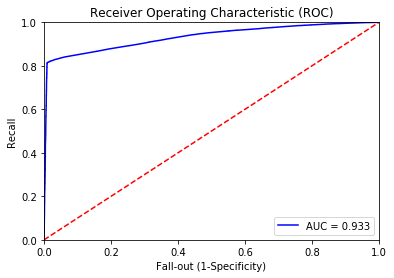

('AUC score:', 0.9327882144533577)


In [63]:
#Print Area Under Curve
plt.figure()
false_positive_rate, recall, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, recall)
plt.title('Receiver Operating Characteristic (ROC)')
plt.plot(false_positive_rate, recall, 'b', label = 'AUC = %0.3f' %roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1], [0,1], 'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.ylabel('Recall')
plt.xlabel('Fall-out (1-Specificity)')
plt.show()

print('AUC score:', roc_auc)

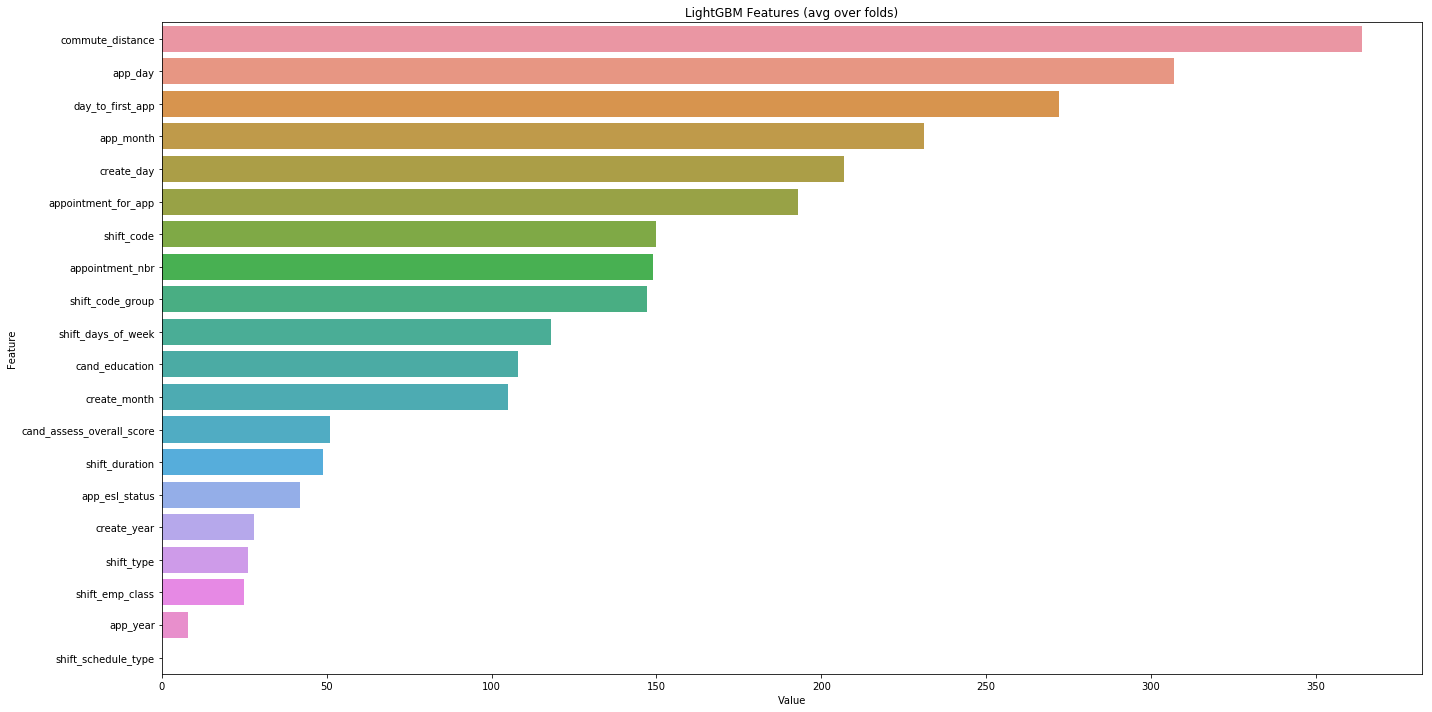

<Figure size 432x288 with 0 Axes>

In [64]:
warnings.simplefilter(action='ignore', category=FutureWarning)

# sorted(zip(clf.feature_importances_, X.columns), reverse=True)
feature_imp = pd.DataFrame(sorted(zip(gbm.feature_importance(),X.columns)), columns=['Value','Feature'])

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()
plt.savefig('lgbm_importances-01.png')

In [65]:
'''
note that best performing CAT boost was not using some features
such as shift_duration, cand_education, cand_assess_overall_score,
shift_days_of_week and shift_startday, here is not shown for semplicity
the one below is not so different in terms of resuls
'''
def auc(m, train, test): 
    return (roc_auc_score(y_train,m.predict_proba(train)[:,1]),
                            roc_auc_score(y_test,m.predict_proba(test)[:,1]))
train, test, y_train, y_test = train_test_split(X, y,
                                                random_state=10, test_size=0.25)
cal_feat = [train.columns.get_loc(c) for c in cat_cols]

clf = CatBoostClassifier(eval_metric="AUC",
                         depth=3,  
                         iterations= 60,
                         #l2_leaf_reg=5,
                         #early_stopping_rounds = True,
                         #od_wait = 10,
                         #class_weights=[1, 1])#,
                         #learning_rate= 0.5, l2_leaf_reg= 9
                        )

clf.fit(train,y_train,cal_feat)
auc(clf, train, test)

Learning rate set to 0.5
0:	total: 143ms	remaining: 8.42s
1:	total: 317ms	remaining: 9.19s
2:	total: 621ms	remaining: 11.8s
3:	total: 1.04s	remaining: 14.5s
4:	total: 1.52s	remaining: 16.7s
5:	total: 2s	remaining: 18s
6:	total: 2.19s	remaining: 16.6s
7:	total: 2.36s	remaining: 15.3s
8:	total: 2.51s	remaining: 14.2s
9:	total: 2.66s	remaining: 13.3s
10:	total: 2.76s	remaining: 12.3s
11:	total: 2.85s	remaining: 11.4s
12:	total: 3.02s	remaining: 10.9s
13:	total: 3.15s	remaining: 10.4s
14:	total: 3.27s	remaining: 9.81s
15:	total: 3.38s	remaining: 9.3s
16:	total: 3.48s	remaining: 8.82s
17:	total: 3.67s	remaining: 8.56s
18:	total: 3.95s	remaining: 8.52s
19:	total: 4.09s	remaining: 8.19s
20:	total: 5.42s	remaining: 10.1s
21:	total: 6.52s	remaining: 11.3s
22:	total: 7.13s	remaining: 11.5s
23:	total: 7.67s	remaining: 11.5s
24:	total: 8.04s	remaining: 11.3s
25:	total: 8.22s	remaining: 10.7s
26:	total: 8.46s	remaining: 10.3s
27:	total: 8.96s	remaining: 10.2s
28:	total: 9.15s	remaining: 9.78s
29:	t

(0.9295575774813166, 0.9307889328027643)

In [66]:
X = np.nan_to_num(X)
clf = LogisticRegression(random_state=0, solver='liblinear', class_weight='balanced', C=0.1, penalty='l2')
pipe = Pipeline([
                # ('scaler' , scaler),
                 #('pca' , pca),
                 #('smote' , smote),
                 #('smoteenn' , smoteenn),
                 ('clf' , clf)])
search_time_start = time.time()
#!!! try with Kfold with smote because by default is stratified 
scores = model_selection.cross_val_score(estimator=pipe,X=X,y=y,cv=5,scoring='roc_auc')

pipe.fit(X,y)

print("search time:", time.time() - search_time_start)
#look how good is the mean and it's distribution
print("Mean AUC:", np.mean(scores)) 
print("Std AUC:",np.std(scores)) 
print("List of scores:",scores)

('search time:', 32.43830990791321)
('Mean AUC:', 0.9237814257351955)
('Std AUC:', 0.0021492058581950896)
('List of scores:', array([0.92347425, 0.9230489 , 0.9213344 , 0.92324468, 0.92780491]))


**Stacking**

*lightGBM* and *CatBoost* were in the region of 0.93, while *Logistic regression* was in 0.92; tried multiple combination giving greater weight to lighGBM who was the best performer.
The best results came from:

$ 0.8*lightGBM + 0.1*CatBoost +0.1*Lr $ 

In [67]:
best_cat = pd.read_csv('../Submission2/guess11.csv', na_values = 'null')
best_light = pd.read_csv('../Submission2/guess5.csv', na_values = 'null')
best_log = pd.read_csv('../Submission2/guess4.csv', na_values = 'null')

ensembled_prediction = best_light
ensembled_prediction['nhenoshow_flag'] = (
    0.1*best_log['nhenoshow_flag']
    +0.1*best_cat['nhenoshow_flag']
    +0.8*best_light['nhenoshow_flag']
    )
ensembled_prediction[['ID','nhenoshow_flag']].to_csv('guessTempEnsemble.csv', index=False)

**Lesson Learned**

   * Go for Low hanging fruits first: Try out simple and quick things 
   * Generalize more than memorize
   * Jupyter handier than Eider
   * LightGBM and CatBoost powerful but need optimization and can take long time to train
   * Most of the value coming out of *Feature Engineering*
   * Stack-ensembling good performing models can give a *tie-breaker*
   * Parameter *Hypertuning* can be time-expensive and must follow Feature Engineering( no sense in doing that before)

